In [1]:
import yfinance as yf 
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

class StockPrediction():
    def __init__(self):
        pass

    def load_yfinance_data(self, enterprise, start_date, end_date):
        yf_df = yf.download(enterprise, start=start_date, end=end_date).reset_index()

        ds = duckdb.sql(f"""
            DROP TABLE IF EXISTS finance;
            CREATE TABLE finance AS ( 
                SELECT
                "('Date', '')" as dt_time
                ,date_trunc('day', "('Date', '')") as dt
                ,"('Adj Close', '{enterprise}')" as adj_close
                ,"('Close', '{enterprise}')" as close
                ,"('High', '{enterprise}')" as high
                ,"('Low', '{enterprise}')" as low
                ,"('Open', '{enterprise}')" as open
                ,"('Volume', '{enterprise}')" as volume

                FROM yf_df
            )
            """)
        
    def get_yfinance_dataset(self):
        finance_dataset = duckdb.sql("""
            SELECT         
                * 
            FROM finance
                """)    
        

        finance_dataset.show()
        
        return finance_dataset.df()
    
    def get_train_n_test(self, test_size = 0.65):
        yfinance_dataset = self.get_yfinance_dataset()

        timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
        dt_time = yfinance_dataset['dt']

        train_size = int(len(timeseries) * test_size)
        test_size = len(timeseries) - train_size
        train, test = timeseries[:train_size], timeseries[train_size:]
        dt_train, dt_test = dt_time[:train_size], dt_time[train_size:]

        return ((dt_train, train), (dt_test, test))
    
    def plot_yfinance_dataset(self, plot_test=False):    

        #yfinance_dataset = self.get_yfinance_dataset()

        #timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
        #dt_time = yfinance_dataset['dt']

        train_test_ds = self.get_train_n_test()


        dt_time = train_test_ds[plot_test][0]
        timeseries = train_test_ds[plot_test][1]


        plt.plot(dt_time, timeseries)
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

        plt.xticks(rotation=45)
        plt.show()         


    def create_torch_dataset(self, dataset, lookback):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-lookback):
            feature = dataset[i:i+lookback]
            target = dataset[i+1:i+lookback+1]
            X.append(feature)
            y.append(target)
        return torch.tensor(X), torch.tensor(y)
        

In [2]:
enterprise = 'GOOGL' 
start_date = '2018-01-01'  
end_date = '2024-07-20' 

stock_p  = StockPrediction()


stock_p.load_yfinance_data(enterprise, start_date, end_date)



[*********************100%***********************]  1 of 1 completed


In [3]:
yfinance_dataset = stock_p.get_yfinance_dataset()

┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────┐
│         dt_time          │            dt            │     adj_close      │       close        │        high        │        low         │        open        │  volume  │
│ timestamp with time zone │ timestamp with time zone │       double       │       double       │       double       │       double       │       double       │  int64   │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────────┤
│ 2018-01-01 22:00:00-02   │ 2018-01-01 00:00:00-02   │   53.5279541015625 │ 53.660499572753906 │  53.79899978637695 │   52.6510009765625 │   52.6510009765625 │ 31766000 │
│ 2018-01-02 22:00:00-02   │ 2018-01-02 00:00:00-02   │  54.44119644165039 │  54.57600021362305 │  54.80500030517578 │  53.67150115966797 │ 

┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────┐
│         dt_time          │            dt            │     adj_close      │       close        │        high        │        low         │        open        │  volume  │
│ timestamp with time zone │ timestamp with time zone │       double       │       double       │       double       │       double       │       double       │  int64   │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────────┤
│ 2018-01-01 22:00:00-02   │ 2018-01-01 00:00:00-02   │   53.5279541015625 │ 53.660499572753906 │  53.79899978637695 │   52.6510009765625 │   52.6510009765625 │ 31766000 │
│ 2018-01-02 22:00:00-02   │ 2018-01-02 00:00:00-02   │  54.44119644165039 │  54.57600021362305 │  54.80500030517578 │  53.67150115966797 │ 

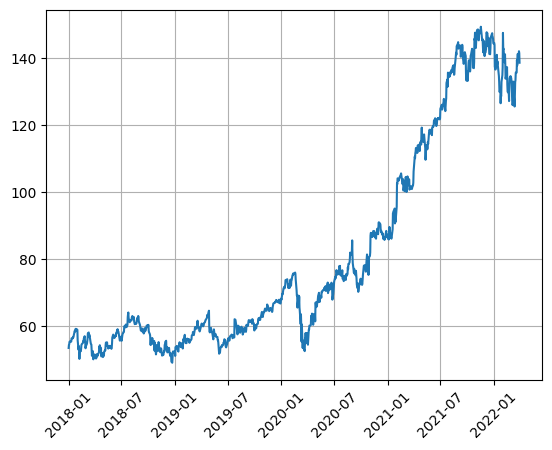

┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────┐
│         dt_time          │            dt            │     adj_close      │       close        │        high        │        low         │        open        │  volume  │
│ timestamp with time zone │ timestamp with time zone │       double       │       double       │       double       │       double       │       double       │  int64   │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────────┤
│ 2018-01-01 22:00:00-02   │ 2018-01-01 00:00:00-02   │   53.5279541015625 │ 53.660499572753906 │  53.79899978637695 │   52.6510009765625 │   52.6510009765625 │ 31766000 │
│ 2018-01-02 22:00:00-02   │ 2018-01-02 00:00:00-02   │  54.44119644165039 │  54.57600021362305 │  54.80500030517578 │  53.67150115966797 │ 

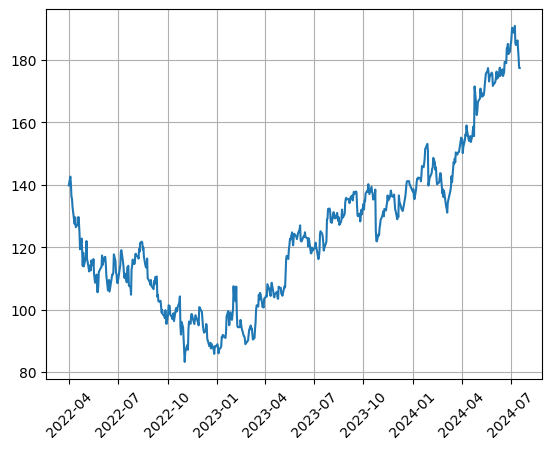

In [4]:
stock_p.plot_yfinance_dataset(False)
stock_p.plot_yfinance_dataset(True)

In [5]:


datasets = stock_p.get_train_n_test(0.65)
train = datasets[0][1]
test = datasets[1][1]

torch.set_num_threads(12)  # Replace 8 with the number of CPU cores you want to use
torch.set_num_interop_threads(10)  # Threads for inter-operation parallelism
 
lookback = 4
X_train, y_train = stock_p.create_torch_dataset(train, lookback=lookback)
X_test, y_test = stock_p.create_torch_dataset(test, lookback=lookback)
 
class StockModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = StockModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 


┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────┐
│         dt_time          │            dt            │     adj_close      │       close        │        high        │        low         │        open        │  volume  │
│ timestamp with time zone │ timestamp with time zone │       double       │       double       │       double       │       double       │       double       │  int64   │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────────┤
│ 2018-01-01 22:00:00-02   │ 2018-01-01 00:00:00-02   │   53.5279541015625 │ 53.660499572753906 │  53.79899978637695 │   52.6510009765625 │   52.6510009765625 │ 31766000 │
│ 2018-01-02 22:00:00-02   │ 2018-01-02 00:00:00-02   │  54.44119644165039 │  54.57600021362305 │  54.80500030517578 │  53.67150115966797 │ 

/tmp/ipykernel_4264/3807304473.py:96: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)
/tmp/ipykernel_4264/3089646378.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_4264/3089646378.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 79.6259, test RMSE 118.5497


┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────┐
│         dt_time          │            dt            │     adj_close      │       close        │        high        │        low         │        open        │  volume  │
│ timestamp with time zone │ timestamp with time zone │       double       │       double       │       double       │       double       │       double       │  int64   │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────────┤
│ 2018-01-01 22:00:00-02   │ 2018-01-01 00:00:00-02   │   53.5279541015625 │ 53.660499572753906 │  53.79899978637695 │   52.6510009765625 │   52.6510009765625 │ 31766000 │
│ 2018-01-02 22:00:00-02   │ 2018-01-02 00:00:00-02   │  54.44119644165039 │  54.57600021362305 │  54.80500030517578 │  53.67150115966797 │ 

/tmp/ipykernel_4264/3136420391.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1, :]
/tmp/ipykernel_4264/3136420391.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


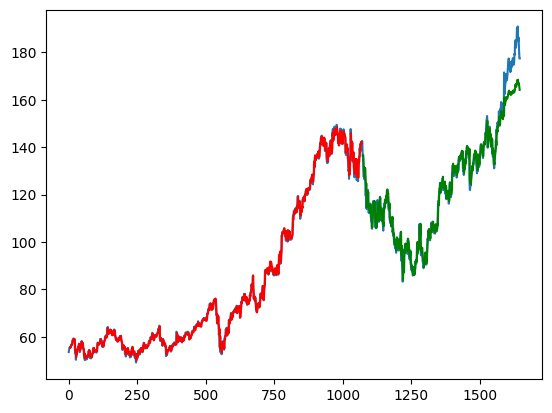

In [6]:
yfinance_dataset = stock_p.get_yfinance_dataset()
test_size = 0.65



timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
train_size = int(len(timeseries) * test_size)

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()